In [ ]:
from os import makedirs
from os import listdir as lsdir
from os.path import join as pjoin
from os.path import exists as exist
from pathlib import Path
import glob
import sys
import pandas as pd
import shutil

import obspy
from obspy.clients.fdsn import Client
from obspy import read,read_inventory,read_events
from obspy.core import Stream,UTCDateTime
from obspy.geodetics.base import gps2dist_azimuth
from obspy.taup import TauPyModel
from obspy.signal.trigger import classic_sta_lta,plot_trigger,recursive_sta_lta,trigger_onset
from obspy.imaging.spectrogram import spectrogram
from obspy.signal.polarization import polarization_analysis
import instaseis

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as patches

## Earthquake Catalog

In [ ]:
cat = read_events("quakes_xml/WafrQuakes90_21.xml")

for e, event in enumerate(cat):
    print(str(e) + "  " + str(event.origins[0].time) + "|" + str(event.magnitudes[0].mag) + " " + cat[0].magnitudes[0].magnitude_type)


In [ ]:
mtau = TauPyModel("iasp91")

### Function to remove duplicate phases from the list of phases arrivals

In [ ]:
#Functions
def Phasett(arr):
  # To correct duplicated phase arrival in list
    P_index_pos_list = [i for i in range(len(arr)) if str(arr[i])[0] == 'P' and str(arr[i])[1] == ' ']
    S_index_pos_list = [i for i in range(len(arr)) if str(arr[i])[0] == 'S' and str(arr[i])[1] == ' ']
    PP_index_pos_list = [i for i in range(len(arr)) if str(arr[i])[0:2] == 'PP'] 
    sP_index_pos_list = [i for i in range(len(arr)) if str(arr[i])[0:2] == 'sP'] 
    pP_index_pos_list = [i for i in range(len(arr)) if str(arr[i])[0:2] == 'pP'] 
    sS_index_pos_list = [i for i in range(len(arr)) if str(arr[i])[0:2] == 'sS'] 
    SS_index_pos_list = [i for i in range(len(arr)) if str(arr[i])[0:2] == 'SS']  


    iP = P_index_pos_list[0]
    iS = S_index_pos_list[0]
    iPP = PP_index_pos_list[0]
    isP = sP_index_pos_list[0]
    ipP = pP_index_pos_list[0]
    isS = sS_index_pos_list[0]
    iSS = SS_index_pos_list[0]

    all_phases = [arr[iP].time,arr[ipP].time,arr[isP].time,arr[iPP].time,arr[iS].time,arr[isS].time,arr[iSS].time]

    PS_Phases = [arr[iP].time,arr[iS].time]

    return PS_Phases,all_phases

## IRIS (+GE.ACRG) Data-----Observations & Selections

### Paths list to data

In [ ]:
path_list = []
for event in cat:
    evid = str(event.origins[0].time)
    evid = evid[0:4] + evid[5:7] + evid[8:13] + evid[14:16] + evid[17:19]
    evloc = event.event_descriptions[0].text
    evid = evloc[:4] + evid
    #pathdir = ("data/events/%s")%evid
    pathdir = ("data/events/%s")%evid
    path_list.append(pathdir)


for eq,eqpath in enumerate(zip(path_list,cat)):
    print(eq)
    print(eqpath[0])
    print(eqpath[1].origins[0].time)


### Data per station

1995-11-25T00:04:41.700000Z
data/events/LIBE19951125T000441


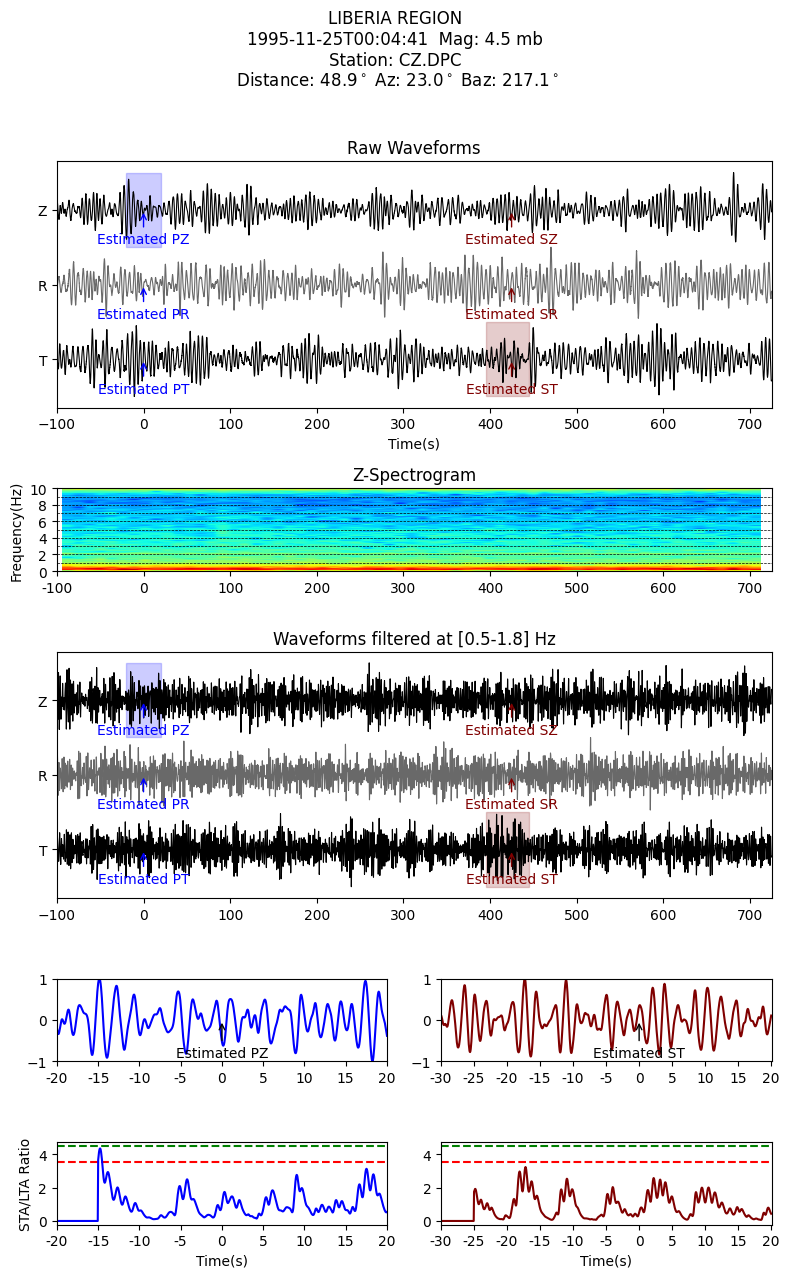

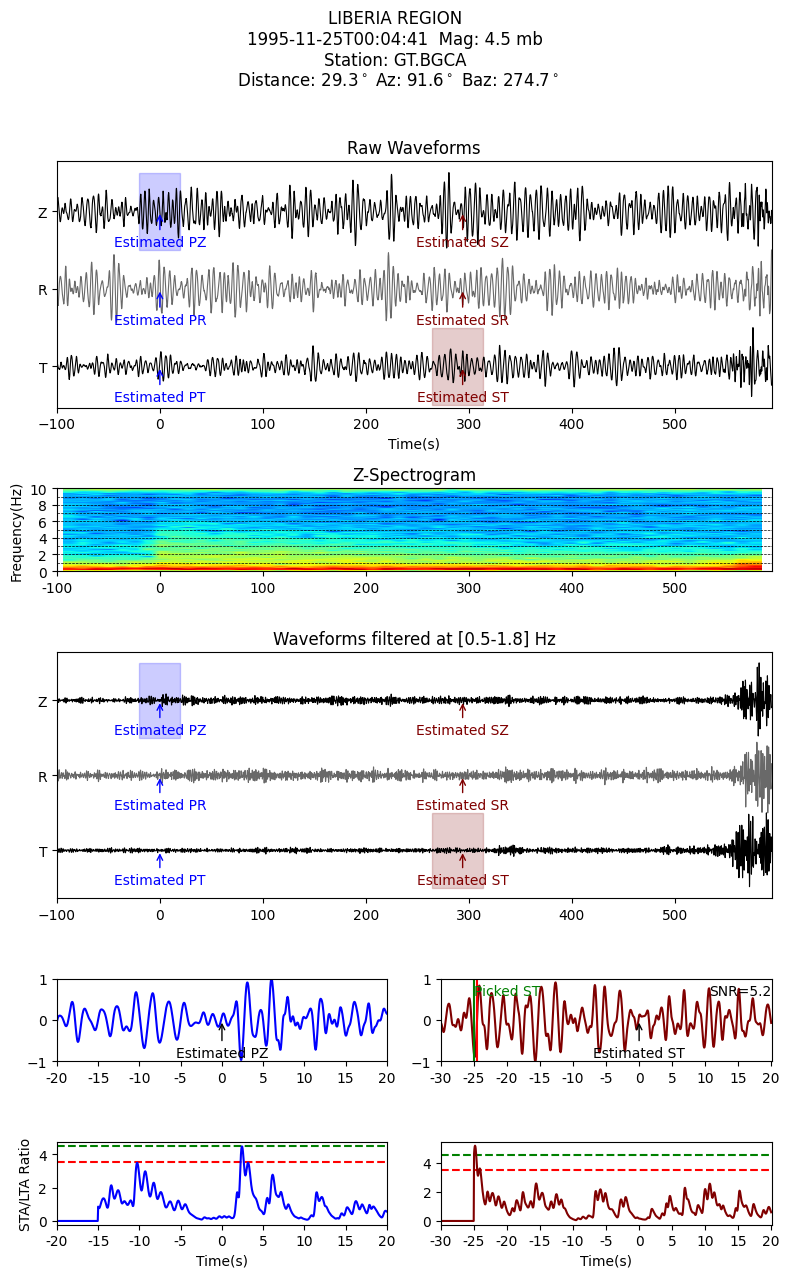

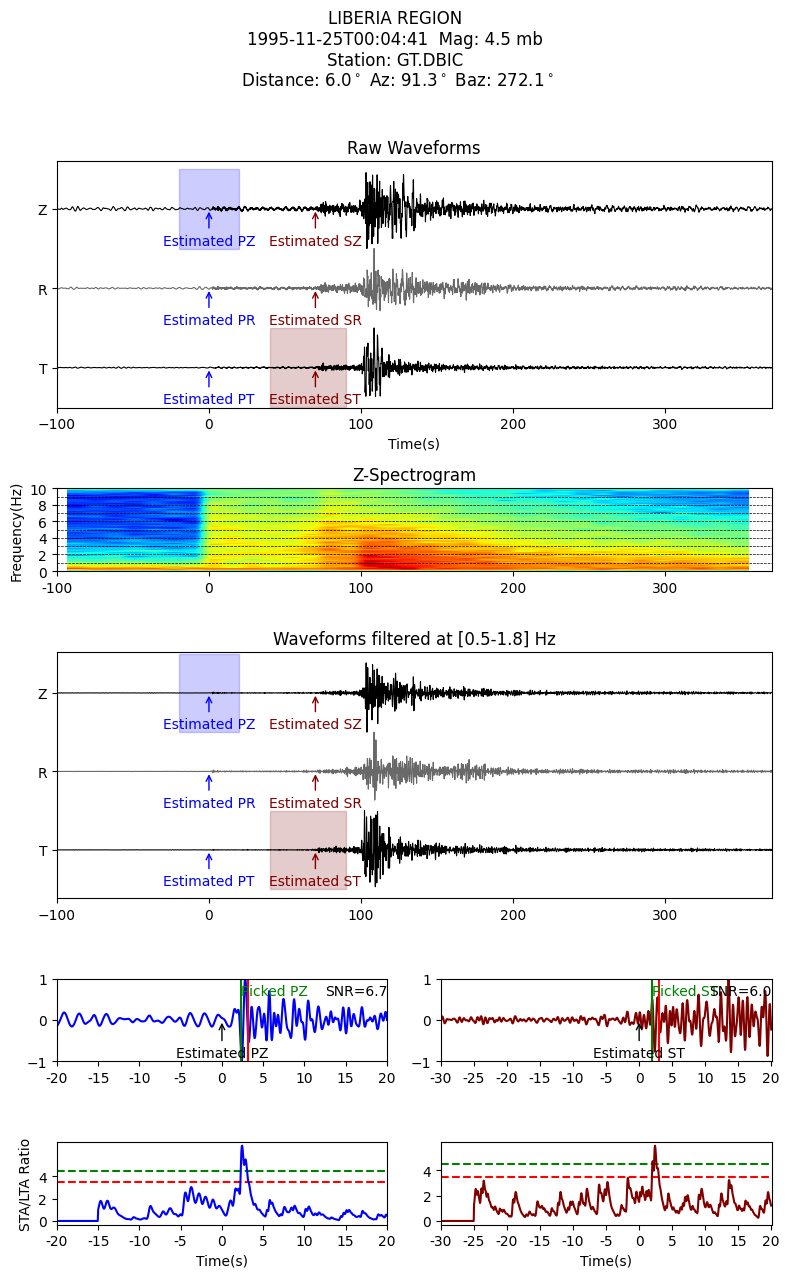

In [6]:
freqmin=0.5
freqmax = 1.8
corners = 3

t_pre_test = [20, 30]
t_post_test = [20, 20]
 
error_writer = open(f'Output/Data_Quality/DataBandpassed%s_%s/error_report/IRISfail_list.csv'%(freqmin,freqmax), 'w')
    
for eq,eqpath in enumerate(zip(path_list,cat)):
    
        event = eqpath[1]
        print(event.origins[0].time)
        datadir = eqpath[0] #data folder
        print(datadir)
        #event info
        try:
            orig_time = event.origins[0].time
            location = event.event_descriptions[0].text
            lat1 = event.origins[0].latitude
            lon1 = event.origins[0].longitude
            mag = str(event.magnitudes[0].mag) + " " + event.magnitudes[0].magnitude_type
        
        except Exception as e:
                   
                exception_type, exception_object, exception_traceback = sys.exc_info()
                line_number = exception_traceback.tb_lineno
                print(line_number)
                error_writer.write(f'{location},{str(orig_time)},{"Code line "+str(line_number)}\n')

        #Output folder
        evid = str(orig_time)
        evid = evid[0:4] + evid[5:7] + evid[8:13] + evid[14:16] + evid[17:19]
        evloc = event.event_descriptions[0].text
        evid = evloc[:4] + evid
       
        outdir = ("Output/Data_Quality/DataBandpassed%s_%s/Summary/IRIS_Data/")%(freqmin,freqmax)
        outfigdir = ("Output/Data_Quality/DataBandpassed%s_%s/Figures/IRIS_Data/")%(freqmin,freqmax)
        
        
        #stations
        try:
            path_to_inventory = pjoin(datadir, ("stations/*"))
            stat_list = lsdir(path_to_inventory[:-1])
            stat_list.sort()
            
            #stations inventory
            inv = obspy.read_inventory(path_to_inventory)
            rec = instaseis.Receiver.parse(inv)

            #stations & waveforms processing display
            for s,sta in enumerate(rec): 

                    station = sta.network +"."+sta.station
                    path_to_waveform = pjoin(datadir,("waveforms/%s*.mseed")%station)

                    lat2 = sta.latitude
                    lon2 = sta.longitude

                    st = obspy.read(path_to_waveform)

                    #Phase arrival times-------------------
                    dist, az, baz = gps2dist_azimuth(lat1, lon1, lat2, lon2, a=6378137.0, f=0.0033528106647474805) #dist(m)
                    dist_km = dist/1000  #dist(km)

                    #Phase arrival times-------------------
                    source_depth_in_m = event.origins[0].depth
                    source_depth_in_km = (source_depth_in_m / 1000)
                    epicentral_distance_degree = dist_km/111

                    arr = mtau.get_travel_times(
                            source_depth_in_km=source_depth_in_km, distance_in_degree=epicentral_distance_degree,
                            phase_list=["P","S","PP", "sP", "pP", "sS", "SS"])
                    
                    try:
                        Phasearrivals = Phasett(arr)

                        All_arr = Phasearrivals[1]
                        P_S_arr = Phasearrivals[0]
                        #print(P_S_arr)
                        ptt = P_S_arr[0]
                        stt = P_S_arr[1]

                        # Detrend and remove instrument response

                        st.detrend(type="linear")
                        st.remove_response(inventory=inv, 
                                                   pre_filt=(0.1,0.3,10,20), 
                                                   output="DISP", 
                                                   zero_mean=True) # correct to displacement
                        st.detrend(type="linear")
                        st.detrend(type="demean") 

                        #Rotate Components RT
                        for tr in st:
                            tr.stats.distance = dist
                            tr.stats.back_azimuth = baz
                        st.rotate(method="NE->RT")

                    except Exception as e:
                            #print("there was an exception %s", str(e))
                            exception_type, exception_object, exception_traceback = sys.exc_info()
                            line_number = exception_traceback.tb_lineno
                            print(line_number)
                            error_writer.write(f'{location},{str(orig_time)},{station},{"Code line "+str(line_number)}\n')

                    # Apply filter and taper the edges
                    st_filt = st.copy()
                    st_filt.filter("bandpass",freqmin=freqmin,freqmax=freqmax,corners=corners,zerophase=True)
                    st_PZST = st_filt.copy()


                    try:
                        #Raw data
                        BHTRaw = st.select(channel="BHT")
                        BHZRaw = st.select(channel="BHZ")
                        BHRRaw = st.select(channel="BHR")
                        BHZRaw = BHZRaw.slice(starttime=orig_time + ptt - 100,
                                               endtime= orig_time + stt + 300,
                                               )
                        BHTRaw = BHTRaw.slice(starttime=orig_time + ptt - 100,
                                               endtime= orig_time + stt + 300,
                                               )

                        BHRRaw = BHRRaw.slice(starttime=orig_time + ptt - 100,
                                               endtime= orig_time + stt + 300,
                                               )

                        #Filterd data
                        BHTwav = st_filt.select(channel="BHT")
                        BHZwav = st_filt.select(channel="BHZ")
                        BHRwav = st_filt.select(channel="BHR")
                        Zwav = st_PZST.select(channel="BHZ")
                        Twav = st_PZST.select(channel="BHT")
                        BHZwav = BHZwav.slice(starttime=orig_time + ptt - 100,
                                               endtime= orig_time + stt + 300,
                                               )
                        BHTwav = BHTwav.slice(starttime=orig_time + ptt - 100,
                                               endtime= orig_time + stt + 300,
                                               )

                        BHRwav = BHRwav.slice(starttime=orig_time + ptt - 100,
                                               endtime= orig_time + stt + 300,
                                               )



                        # P-phase sliced
                        Slice_PZ = Zwav.slice(starttime=orig_time + ptt - t_pre_test[0],
                                               endtime= orig_time + ptt + t_post_test[0],
                                               )
                        # S-phase sliced
                        Slice_ST = Twav.slice(starttime=orig_time + stt - t_pre_test[1],
                                                       endtime=orig_time + stt + t_post_test[1],
                                               )


                        ymin = -1
                        ymax = 1

                        trZ = BHZwav.traces[0].data
                        trZ /= max(abs(trZ))
                        trT = BHTwav.traces[0].data
                        trT /= max(abs(trT))
                        trR = BHRwav.traces[0].data
                        trR /= max(abs(trR))


                        trPZ = Slice_PZ.traces[0].data
                        trPZ /= max(abs(trPZ))
                        dtPZ = Slice_PZ.traces[0].stats.sampling_rate
                        trST = Slice_ST.traces[0].data
                        trST /= max(abs(trST))
                        dtST =Slice_ST.traces[0].stats.sampling_rate


                        plt.style.use('default')
                        plt.rcParams["figure.figsize"] = (8,13)


                        #1
                        ax1 = plt.subplot2grid((8, 2), (1, 0), colspan=2,rowspan=2)
                        Zraw = BHZRaw.traces[0].data
                        Zraw = Zraw / max(abs(Zraw))
                        Traw = BHTRaw.traces[0].data
                        Traw = Traw / max(abs(Traw))
                        Rraw = BHRRaw.traces[0].data
                        Rraw /= max(abs(Rraw))
                        timeRaw = BHZRaw.traces[0].times()
                        timeRaw = timeRaw - 100 
                        ax1.plot(timeRaw,Zraw,color="black",linewidth=0.8)
                        ax1.plot(timeRaw,Rraw-2,color="dimgrey",linewidth=0.8)
                        ax1.plot(timeRaw,Traw-4,color="black",linewidth=0.8)

                        ax1.set_xlim(min(timeRaw),max(timeRaw))
                        ax1.set_yticks([-4,-2,0])
                        ax1.set_yticklabels(['T','R','Z'])
                        ax1.set_xticks(range(-100,int(max(timeRaw)),100))
                        ax1.set_title('Raw Waveforms')
                        ax1.set_xlabel("Time(s)")
                        for i,comp in zip([0,2,4],["Z","R","T"]):

                            ax1.annotate('Estimated P%s'%comp, xy=(0.0,0.0-i),
                            xytext=(0.0, -0.9-i),color="blue",ha='center',
                            arrowprops=dict(arrowstyle="->",color = "blue")
                            )
                            ax1.annotate('Estimated S%s'%comp, xy=(stt-ptt,0.0-i),
                            xytext=((stt-ptt), -0.9-i),color="maroon",ha='center',
                            arrowprops=dict(arrowstyle="->",color = "maroon")
                            )

                        ax1.add_patch(
                        patches.Rectangle(
                        (-t_pre_test[0], -1.0), # (x,y)
                        (t_pre_test[0]+t_post_test[0]), #width
                        2, # height
                        alpha=0.2, facecolor="blue", edgecolor="blue", linewidth=1, linestyle='solid'))

                        ax1.add_patch(
                        patches.Rectangle(
                        (stt-ptt - t_pre_test[1], -5.0), # (x,y)
                        (t_pre_test[1]+t_post_test[1]), #width
                        2, # height
                        alpha=0.2, facecolor="maroon", edgecolor="maroon", linewidth=1, linestyle='solid'))


                        #2
                        ax2 = plt.subplot2grid((8, 2), (3, 0), colspan=2)
                        dt = BHZRaw.traces[0].stats.delta

                        samp_rate = BHZRaw.traces[0].stats.sampling_rate
                        trace_data = BHZRaw.traces[0].data
                        ax2.specgram(trace_data, NFFT=512, Fs=samp_rate, Fc=None, detrend=None, window=None, 
                                   noverlap=256, cmap="jet", xextent=None, pad_to=None, 
                                   sides=None, scale_by_freq=None, mode=None, scale=None, 
                                   vmin=None, vmax=None, data=None)
                        ax2.set_ylim(0,10)
                        ax2.set_yticks(np.arange(0,12,2))


                        ax2.hlines(np.arange(0,11,1),0, len(timeRaw)*dt,color='Black', linestyle='--',linewidth=0.5)
                        #ax2.set_xlim(0,max(timeRaw))
                        ax2.set_xlim(0,len(timeRaw)*dt)
                        ax2.set_xticks(range(0,int(len(timeRaw)*dt),100))
                        ax2.set_xticklabels(np.arange(-100,int(len(timeRaw)*dt),100))

                        #ax2.set_xticklabels(np.arange(-100,len(timeRaw)*dt,100))
                        ax2.set_title('Z-Spectrogram')
                        ax2.set_ylabel("Frequency(Hz)")

                        #3
                        ax3= plt.subplot2grid((8, 2), (4, 0), colspan=2,rowspan=2)

                        timeZ = BHZwav.traces[0].times()
                        timeZ = timeZ - 100 
                        ax3.plot(timeZ,trZ,color="black",linewidth=0.8)
                        ax3.plot(timeZ,trR-2,color="dimgrey",linewidth=0.8)
                        ax3.plot(timeZ,trT-4,color="black",linewidth=0.8)
                        ax3.set_xlim(min(timeZ),max(timeZ))
                        ax3.set_yticks([-4,-2,0])
                        ax3.set_yticklabels(['T','R','Z'])
                        ax3.set_xticks(range(-100,int(max(timeRaw)),100))
                        ax3.set_title('Waveforms filtered at [%s-%s] Hz'%(freqmin,freqmax))

                        for i,comp in zip([0,2,4],["Z","R","T"]):

                            ax3.annotate('Estimated P%s'%comp, xy=(0.0,0.0-i),
                            xytext=(0.0, -0.9-i),color="blue",ha='center',
                            arrowprops=dict(arrowstyle="->",color = "blue")
                            )
                            ax3.annotate('Estimated S%s'%comp, xy=(stt-ptt,0.0-i),
                            xytext=((stt-ptt), -0.9-i),color="maroon",ha='center',
                            arrowprops=dict(arrowstyle="->",color = "maroon")
                            )

                        ax3.add_patch(
                        patches.Rectangle(
                        (-t_pre_test[0], -1.0), # (x,y)
                        (t_pre_test[0]+t_post_test[0]), #width
                        2, # height
                        alpha=0.2, facecolor="blue", edgecolor="blue", linewidth=1, linestyle='solid'))

                        ax3.add_patch(
                        patches.Rectangle(
                        (stt-ptt - t_pre_test[1], -5.0), # (x,y)
                        (t_pre_test[1]+t_post_test[1]), #width
                        2, # height
                        # You can add rotation as well with 'angle'
                        alpha=0.2, facecolor="maroon", edgecolor="maroon", linewidth=1, linestyle='solid'))


                        # PZ & ST Phase Detection and Quality Analysis
                        trg = [4.5,3.5]
                        STL= 10#10
                        LTL = 100#100

                        cftP = recursive_sta_lta(trPZ,STL,LTL)
                        on_ofP= trigger_onset(cftP,trg[0],trg[1])


                        cftS= recursive_sta_lta(trST,STL,LTL)
                        on_ofS = trigger_onset(cftS,trg[0],trg[1])

                        #set x_tick labels PZ
                        delta = Slice_PZ.traces[0].stats.delta
                        npts = Slice_PZ.traces[0].stats.npts
                        tmax = int(npts * delta)

                        #P
                        ax4 = plt.subplot2grid((8,2), (6, 0), colspan=1)

                        ax4.plot(trPZ,'blue')
                        ax4.set_xlim(0,npts)
                        ax4.set_xticks(np.arange(0,npts,5/delta))
                        ax4.set_xticklabels(np.arange(-t_pre_test[0],(tmax+5)-t_pre_test[0],5))  

                        ax4.set_yticks(np.arange(-1,2,1))
                        ax4.set_ylim(-1,1)
                        if len(on_ofP) != 0:
                            P_SNR = round(cftP[on_ofP[:, 0][0]:on_ofP[:, 1][0]].max(),1)
                            ax4.axvline(on_ofP[:, 0][0],color='g', linewidth=1.5)
                            ax4.text(on_ofP[:, 0][0],0.6,"Picked PZ",color='g')
                            ax4.text(npts,0.6,"SNR=%s"%P_SNR,color='black',ha="right")
                            ax4.axvline(on_ofP[:, 1][0], color='r',linewidth=1.5)
                            pick = max(cftP)
                            indpick = list(cftP).index(pick)
                            P_corr = round(indpick*delta-t_pre_test[0] ,1)


                        #annotation
                        xan= t_pre_test[0]/delta
                        xtext= t_pre_test[0]/delta
                        ax4.annotate('Estimated PZ', xy=(xan,0.0),
                        xytext=(xtext, -0.9),color="black",ha='center',
                        arrowprops=dict(arrowstyle="->",color = "black")
                        )


                        ax5 = plt.subplot2grid((8, 2), (7,0), colspan=1) 
                        ax5.plot(cftP,'blue')
                        ax5.set_yticks(np.arange(0,6,2))
                        ax5.set_xlim(0,npts)
                        ax5.set_xticks(np.arange(0,npts,5/delta))
                        ax5.set_xticklabels(np.arange(-t_pre_test[0],(tmax+5)-t_pre_test[0],5))
                        ax5.hlines([trg[0],trg[1]], 0, len(cftP),color=['g', 'r'], linestyle='--')
                        ax5.set_ylabel("STA/LTA Ratio")
                        ax5.set_xlabel("Time(s)")

                        #set x_tick labels ST
                        delta = Slice_ST.traces[0].stats.delta
                        npts = Slice_ST.traces[0].stats.npts
                        tmax = int(npts * delta)

                        #S
                        ax6= plt.subplot2grid((8,2), (6,1), colspan=1)
                        ax6.plot(trST,'maroon')
                        ax6.set_xlim(0,npts)
                        ax6.set_xticks(np.arange(0,npts,5/delta))
                        ax6.set_xticklabels(np.arange(-t_pre_test[1],(tmax+5)-t_pre_test[1],5))

                        ax6.set_yticks(np.arange(-1,2,1))
                        ax6.set_ylim(-1,1)
                        if len(on_ofS) != 0:
                            S_SNR = round(cftS[on_ofS[:, 0][0]:on_ofS[:, 1][0]].max(),1)
                            ax6.axvline(on_ofS[:, 0][0],color='g', linewidth=1.5)
                            ax6.text(on_ofS[:, 0][0],0.6,"Picked ST",color='g')
                            ax6.text(npts,0.6,"SNR=%s"%S_SNR,color='black',ha="right")
                            ax6.axvline(on_ofS[:, 1][0], color='r', linewidth=1.5)
                            pick = max(cftS)
                            indpick = list(cftS).index(pick)
                            S_corr = round(indpick*delta-t_pre_test[1] ,1)

                        #annotation
                        xan= t_pre_test[1]/delta
                        xtext= t_pre_test[1]/delta
                        ax6.annotate('Estimated ST', xy=(xan,0.0),
                        xytext=(xtext, -0.9),color="black",ha='center',
                        arrowprops=dict(arrowstyle="->",color = "black")
                        )   


                        ax7= plt.subplot2grid((8, 2), (7,1), colspan=1) #plt.subplot(212, sharex=ax
                        ax7.plot(cftS,'maroon')
                        ax7.set_yticks(np.arange(0,6,2))
                        ax7.set_xlim(0,npts)
                        #ax7.set_xticks(np.arange(0,npts,200))
                        ax7.set_xticks(np.arange(0,npts,5/delta))
                        ax7.set_xticklabels(np.arange(-t_pre_test[1],(tmax+5)-t_pre_test[1],5))
                        ax7.hlines([trg[0],trg[1]], 0, len(cftS),color=['g', 'r'], linestyle='--')
                        ax7.set_xlabel("Time(s)")


                        plt.tight_layout()
                        plt.suptitle("%s\n%s  Mag: %s\nStation: %s\n Distance: %s$^\circ$ Az: %s$^\circ$ Baz: %s$^\circ$"%(location,str(orig_time)[0:19],mag,station,
                                                                                        round(epicentral_distance_degree,1),round(az,1),
                                                                                        round(baz,1)),horizontalalignment ="center")
                        plt.gcf()
                        plt.show()


                        # save relevant information for each earthquake
                        event_out = (
                                    "{country:s},{origin:s},"
                                    "{lon:.2f},{lat:.2f},{depth:.2f},"
                                    "{mag:.1f},{magtype:s},"
                                    "{station:s},{stlon:.2f},{stlat:.2f},"
                                    "{Pick_P:s},{P_corr:.1f},{P_SNR:.1f},"
                                    "{Pick_S:s},{S_corr:.1f},{S_SNR:.1f}\n"
                                    )    

                        if len(on_ofP) != 0 and len(on_ofS) == 0: 
                            #print("Station %s only has P data"%station)
                            #print("P_corr = %s"%P_corr) 
                            Pick_P_value= "Yes"
                            P_corr_value= P_corr
                            P_SNR_value= P_SNR
                            Pick_S_value= "No"
                            S_corr_value= 0
                            S_SNR_value= 0
                            outfilepath = pjoin(outdir,"IRIS_event_picked_P.csv")
                            outfigpath = pjoin(outfigdir,"IRIS_event_picked_P/%s")%evid
                        elif len(on_ofP) == 0 and len(on_ofS) != 0: 
                            #print("Station %s  only has S data"%station) 
                            #print("S_corr=%s"%S_corr)
                            Pick_P_value= "No"
                            P_corr_value= 0
                            P_SNR_value= 0
                            Pick_S_value= "Yes"
                            S_corr_value= S_corr
                            S_SNR_value= S_SNR
                            outfilepath = pjoin(outdir,"IRIS_event_picked_S.csv")
                            outfigpath = pjoin(outfigdir,"IRIS_event_picked_S/%s")%evid
                        elif len(on_ofP) != 0 and len(on_ofS) != 0: 
                            #print("Station %s has useful data"%station)
                            #print("P_corr = %s & S_corr=%s"%(P_corr,S_corr)) 
                            Pick_P_value= "Yes"
                            P_corr_value= P_corr
                            P_SNR_value= P_SNR
                            Pick_S_value= "Yes"
                            S_corr_value= S_corr
                            S_SNR_value= S_SNR
                            outfilepath = pjoin(outdir,"IRIS_event_picked_P_S.csv")
                            outfigpath = pjoin(outfigdir,"IRIS_event_picked_P_S/%s")%evid
                        else: 
                            #print("Station %s has no useful data"%station)
                            Pick_P_value= "No"
                            P_corr_value= 0
                            P_SNR_value= 0
                            Pick_S_value= "No"
                            S_corr_value= 0
                            S_SNR_value= 0
                            outfilepath = pjoin(outdir,"IRIS_event_nopicked_P_S.csv")                   
                            outfigpath = pjoin(outfigdir,"IRIS_event_nopicked_P_S/%s")%evid

                        #Save CSV files  
                        event_out = event_out.format(
                                        country=location,
                                        origin=str(orig_time),
                                        lon=lon1,
                                        lat=lat1,
                                        depth=source_depth_in_km,
                                        mag=event.magnitudes[0].mag,
                                        magtype=event.magnitudes[0].magnitude_type,
                                        station= station,
                                        stlon = lon2,
                                        stlat = lat2,
                                        Pick_P= Pick_P_value,
                                        P_corr= P_corr_value,
                                        P_SNR= P_SNR_value,
                                        Pick_S= Pick_S_value,
                                        S_corr= S_corr_value,
                                        S_SNR= S_SNR_value,
                                        )  

                        outfile = outfilepath
                        if not exist(outfile):
                            Path(outdir).mkdir(parents=True,exist_ok=True)
                            with open(outfile,"w") as f:
                                f.write("country,origin,lon,lat,depth,mag,magtype,station,stlon,stlat,Pick_P,P_corr,P_SNR,Pick_S,S_corr,S_SNR\n")
                        with open(outfile,"a") as f:
                             f.write(event_out)

                        #save figure
                        outfig = outfigpath
                        if not exist(outfig):
                            Path(outfig).mkdir(parents=True,exist_ok=True)

                        plt.savefig(
                            pjoin(
                                outfig,
                                f"SignalDetection_{location}_{str(orig_time)[0:19]}_{station}_.pdf",
                            ),
                            dpi=600,
                            )
                        plt.show()
                        plt.close()


                    except Exception as e:

                        exception_type, exception_object, exception_traceback = sys.exc_info()
                        line_number = exception_traceback.tb_lineno
                        error_writer.write(f'{location},{str(orig_time)},{station},{"Code line " + str(line_number)}\n')
                        print(line_number)
        except Exception as e:

                exception_type, exception_object, exception_traceback = sys.exc_info()
                line_number = exception_traceback.tb_lineno
                error_writer.write(f'{location},{str(orig_time)},{"Code line " + str(line_number)}\n')
                print(line_number)

error_writer.close()
